# Traffic Sign Recognition

## Summary

This notebook contains a model trained to identify traffic signs using a convolutional neural network or CNN. The dataset used to train and test the model was obtained through Kaggle. The dataset contains over 51,000 images that are split into three categories (Meta, Train, and Test.) There are also three .csv files of the same names that contain data related to the images.
- **Meta** - the control group that contain one image of each traffic sign classification.
- **Train** - the images that will be used to train the model
- **Test** - the images used to test the model. The model wioll never have seen these images until after it has been trained and tuned
- Source: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/

In [1]:
#!pip install keras-tuner -q

In [2]:
# Import the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
import keras_tuner as kt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten

%matplotlib inline

Using TensorFlow backend


In [3]:
# Create variables to hold the folder paths to the data 
data_path = os.getcwd() + '/data'
train_path = os.getcwd() + '/data/Train'

In [4]:
# Get the number of sign categories/classifications
# This will be used later for the output layer of the model
categories = len(os.listdir(train_path))

print(categories)

43


#### There are 43 categories total, but they are only numbers right now. The categories need labels/names.

In [5]:
# Create a dictionary of all the sign categories
#   A dictiponary is used to better keep track of the original label number and its new name.
#   The Meta folder is used to identify what label number corresponds to what image.
#     This is done manually outside of the notebook.
#   Label names taken from https://www.iamexpat.de/expat-info/driving-germany/road-signs

labels = {0:'Speed limit (20km/h)', 1:'Speed limit (30km/h)', 
          2:'Speed limit (50km/h)', 3:'Speed limit (60km/h)',
          4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)',
          6:'End of speed limit', 7:'Speed limit (100km/h)',
          8:'Speed limit (120km/h)', 9:'No passing',
          10:'No passing vehicles over 3.5 tons',
          11:'Priority/Right of way at next intersection',
          12:'Priority road', 13:'Yield', 14:'Stop', 
          15:'Road closed', 16:'Vehicles over 3.5 tons prohibited',
          17:'Do not enter', 18:'General danger',
          19:'Curve left', 20:'Curve right', 21:'Double curve', 
          22:'Uneven road surface', 23:'Slippery when wet/dirty', 
          24:'Road narrows on right', 25:'Road work', 
          26:'Traffic signals ahead', 27:'Pedestrians',
          28:'Watch for children', 29:'Bicycle crossing', 30:'Ice/snow',
          31:'Wild animal crossing', 32:'End of all speed and passing restrictions',
          33:'Turn right ahead', 34:'Turn left ahead', 35:'Ahead only', 
          36:'Ahead or right turn', 37:'Ahead or left turn',
          38:'Pass by on right', 39:'Pass by on left', 40:'Roundabout',
          41:'End of no passing', 42:'End of no passing vehicles over 3.5 tons'}

## Exploratory Data Analysis

Time to start visualizing what exactly this notebook is working with.

In [6]:
# Create a dataframe to visualize the training data and display the head
trainDF = pd.read_csv('data/Train.csv')

trainDF.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


There are eight columns:
- **Width** - width of the image
- **Height** - height of the image
- **Roi.X1** - upper left x-coordinate of the sign
- **Roi.Y1** - upper left y-coordinate of the sign
- **Roi.X2** - bottom right x-coordinate of the sign
- **Roi.Y2** - bottom right y-coordinate of the sign
- **ClassId** - the number label of the sign
- **Path** - the filepath of the image

The x-y coordinates are not needed so they will be dropped. A new column containing the label names will also be added to better visualize the data.

The images also have various sizes, so they need to be resized later on.

In [7]:
# Drop x-y coordinate columns and display the head of the dataframe
trainDF = trainDF.drop(['Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2'], axis=1)

trainDF.head()

,Width,Height,ClassId,Path
0,27,26,20,Train/20/00020_00000_00000.png
1,28,27,20,Train/20/00020_00000_00001.png
2,29,26,20,Train/20/00020_00000_00002.png
3,28,27,20,Train/20/00020_00000_00003.png
4,28,26,20,Train/20/00020_00000_00004.png


In [8]:
# Add a Labels column of label names using the dictionary created earlier
trainDF['Labels'] = trainDF['ClassId'].map(labels)
trainDF.head()

,Width,Height,ClassId,Path,Labels
0,27,26,20,Train/20/00020_00000_00000.png,Curve right
1,28,27,20,Train/20/00020_00000_00001.png,Curve right
2,29,26,20,Train/20/00020_00000_00002.png,Curve right
3,28,27,20,Train/20/00020_00000_00003.png,Curve right
4,28,26,20,Train/20/00020_00000_00004.png,Curve right


In [9]:
# Display the dataframe's info
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   ClassId  39209 non-null  int64 
 3   Path     39209 non-null  object
 4   Labels   39209 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.5+ MB


#### There are 39,209 images in the training dataset according to the dataframe.

In [10]:
# Create a dataframe to visualize the test data and display the head
testDF = pd.read_csv('data/Test.csv')

testDF.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


#### The test dataframe is identical to the training dataframe so the same changes will be made.

In [11]:
# Drop x-y coordinate columns and display the head
testDF = testDF.drop(['Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2'], axis=1)

testDF.head()

,Width,Height,ClassId,Path
0,53,54,16,Test/00000.png
1,42,45,1,Test/00001.png
2,48,52,38,Test/00002.png
3,27,29,33,Test/00003.png
4,60,57,11,Test/00004.png


In [12]:
# Add a Labels column of label names
testDF['Labels'] = testDF['ClassId'].map(labels)
testDF.head()

,Width,Height,ClassId,Path,Labels
0,53,54,16,Test/00000.png,Vehicles over 3.5 tons prohibited
1,42,45,1,Test/00001.png,Speed limit (30km/h)
2,48,52,38,Test/00002.png,Pass by on right
3,27,29,33,Test/00003.png,Turn right ahead
4,60,57,11,Test/00004.png,Priority/Right of way at next intersection


In [13]:
# Display the dataframe's info
testDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    12630 non-null  int64 
 1   Height   12630 non-null  int64 
 2   ClassId  12630 non-null  int64 
 3   Path     12630 non-null  object
 4   Labels   12630 non-null  object
dtypes: int64(3), object(2)
memory usage: 493.5+ KB


#### There are 12,630 images in the test dataset.

Now it is time to plot the dataframes to better visualize how many images there are and how many are in each category.

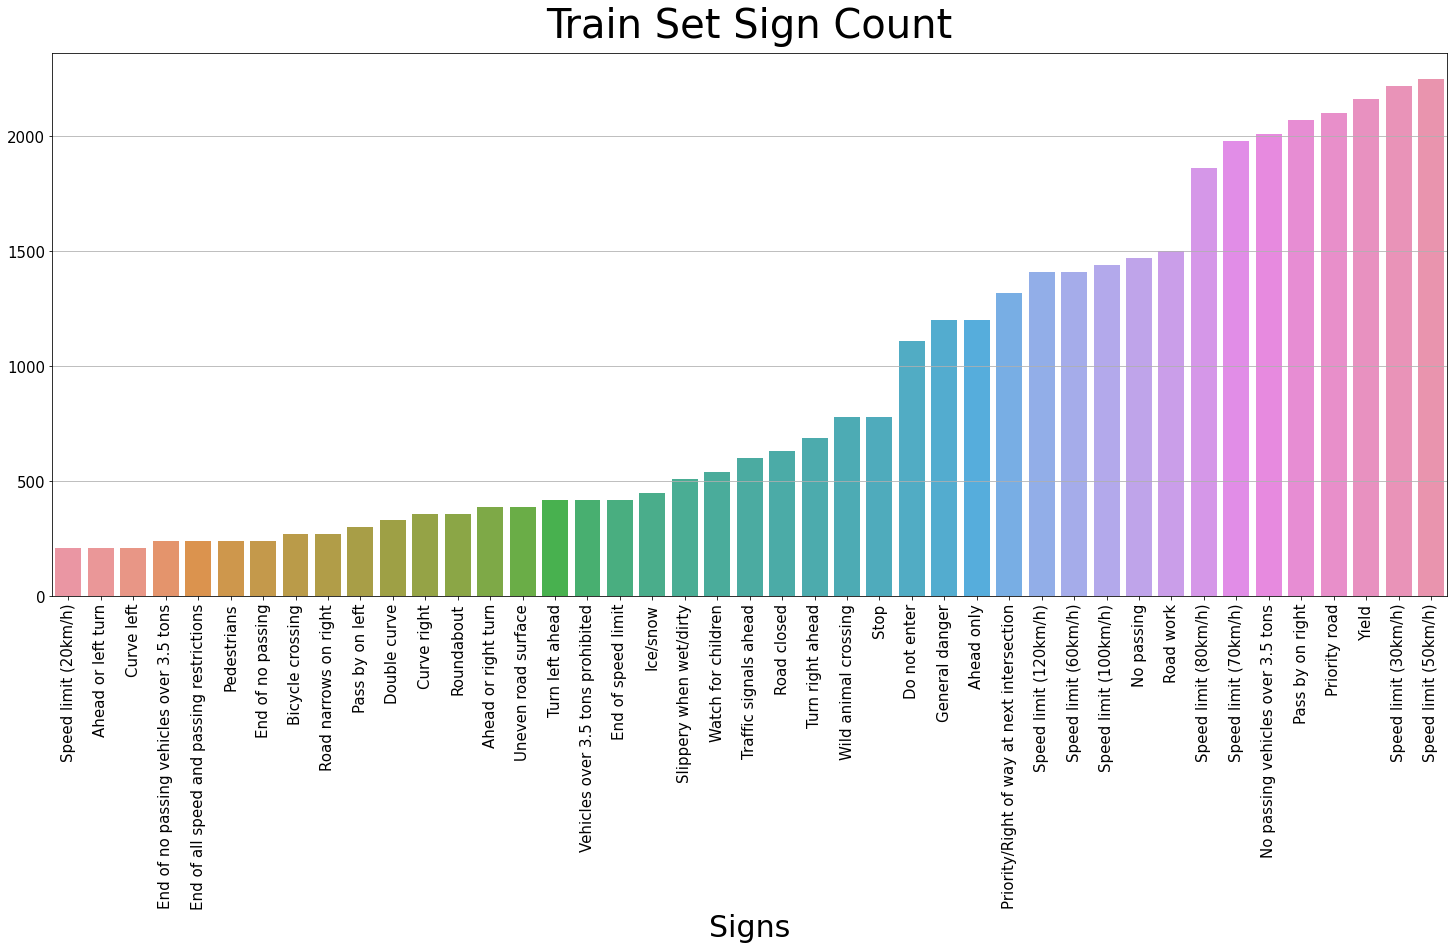

In [14]:
# Set graph size
plt.figure(figsize=(25,10))
# Create a countplot of the label names
sns.countplot(data=trainDF, x='Labels',
              order=trainDF['Labels'].value_counts(ascending=True).index)
# Set the title
plt.title('Train Set Sign Count', fontsize=40, pad=15)
# Set the x-axis label
plt.xlabel('Signs', fontsize=30)
# Remove y-axis label
plt.ylabel('')
# Rotate the x-tick label names
plt.xticks(rotation='vertical')
# Set tick label size
plt.tick_params(axis='both', labelsize=15)
# Add horizontal gridlines
plt.grid(axis='y')
# Display the graph
plt.show()

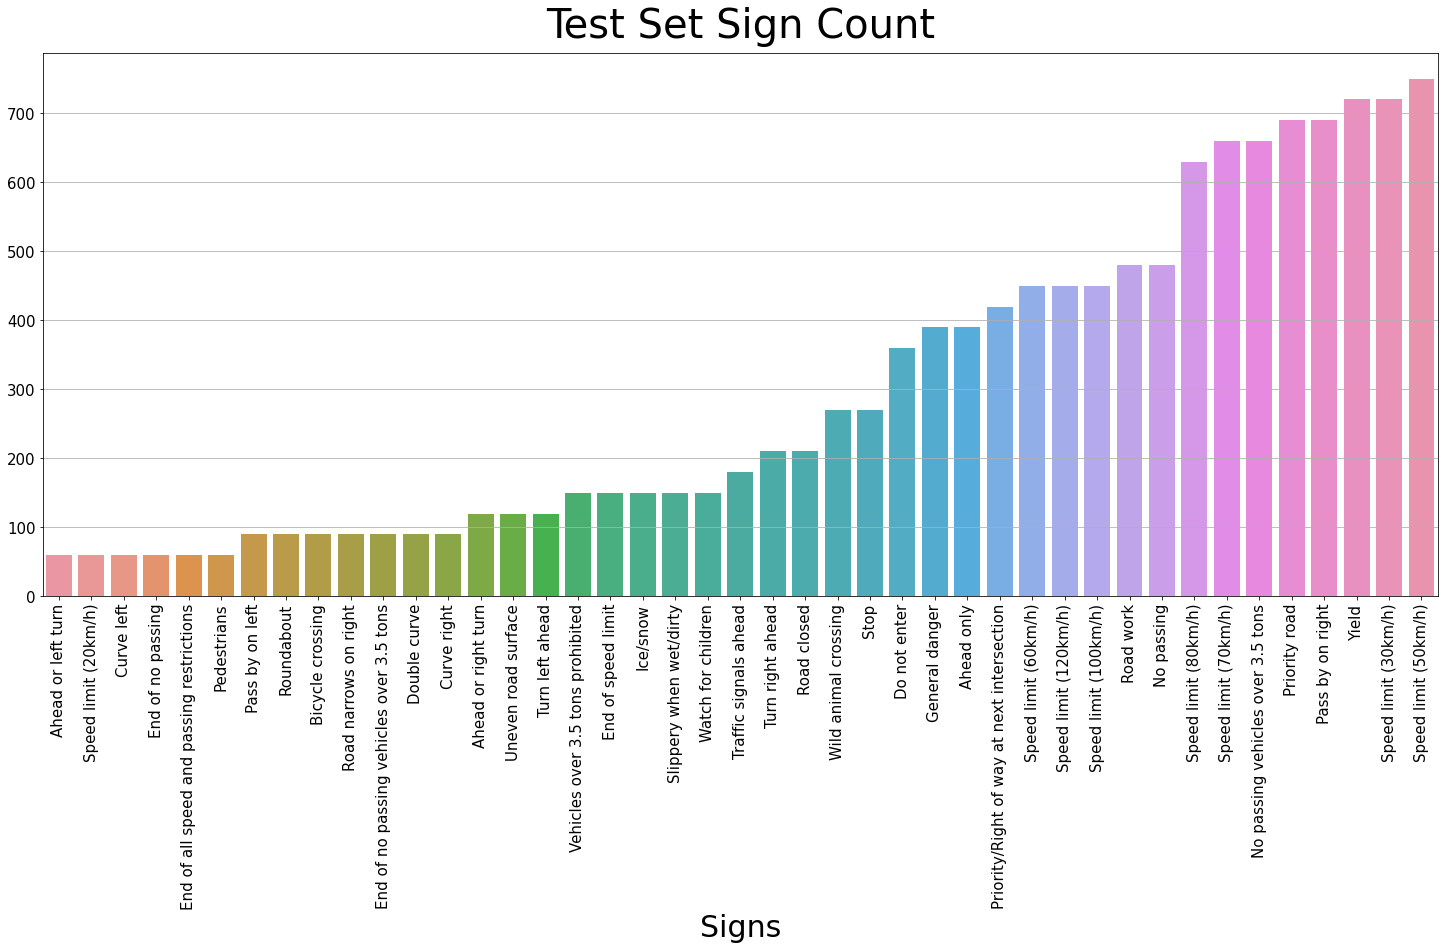

In [15]:
# Set graph size
plt.figure(figsize=(25,10))
# Create a countplot of the label names
sns.countplot(data=testDF, x='Labels',
              order=testDF['Labels'].value_counts(ascending=True).index)
# Set the title
plt.title('Test Set Sign Count', fontsize=40, pad=15)
# Set the x-axis label
plt.xlabel('Signs', fontsize=30)
# Remove y-axis label
plt.ylabel('')
# Rotate the x-tick label names
plt.xticks(rotation='vertical')
# Set tick label size
plt.tick_params(axis='both', labelsize=15)
# Add horizontal gridlines
plt.grid(axis='y')
# Display the graph
plt.show()

There is an imbalance of sign data in both the training set and the testing set, but the imbalance seems to be consistent, meaning the ratios in both datasets should be the same. Hopefully, the imbalance won't cause too many problems for the model.

## Data Preprocessing and More EDA

The images need to be converted into a usable form for the model.

In [16]:
# Create empty lists to store the data
images = []
imgLabels = []

# For loop to iterate through all the folders and images in the training set
for i in range(categories):
    # Variables for the image filepath
    tempPath = train_path + '/' + str(i)
    imagePath = os.listdir(tempPath)
    
    # For loop to itertae through the images in each category
    for img in imagePath:
        # Create an array using the images and resize the image to 28x28
        tempArray = np.array(Image.open(tempPath+'/'+img).resize((28,28)))
        # Add the array to the image list created earlier
        images.append(tempArray)
        # Add the number label/ClassId to the label list created earlier
        imgLabels.append(i)

# Convert the lists into arrays
imageArray = np.array(images)
labelArray = np.array(imgLabels)

# Print the shapes of the arrays
print(imageArray.shape)
print(labelArray.shape)

(39209, 28, 28, 3)
(39209,)


In [17]:
# Split the data into training and validation sets for the model
#   Random state 42 will be used to keep training and testing consistent
X_train, X_valid, y_train, y_valid = train_test_split(imageArray, labelArray, test_size=0.3, random_state=42)

# Print out the shapes of the datasets
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(27446, 28, 28, 3)
(27446,)
(11763, 28, 28, 3)
(11763,)


#### Time to see what these images actaully look like.

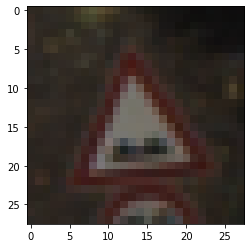

In [18]:
# Plot a random image from the training set
plt.imshow(X_train[random.randint(0, 27446)])
plt.show()

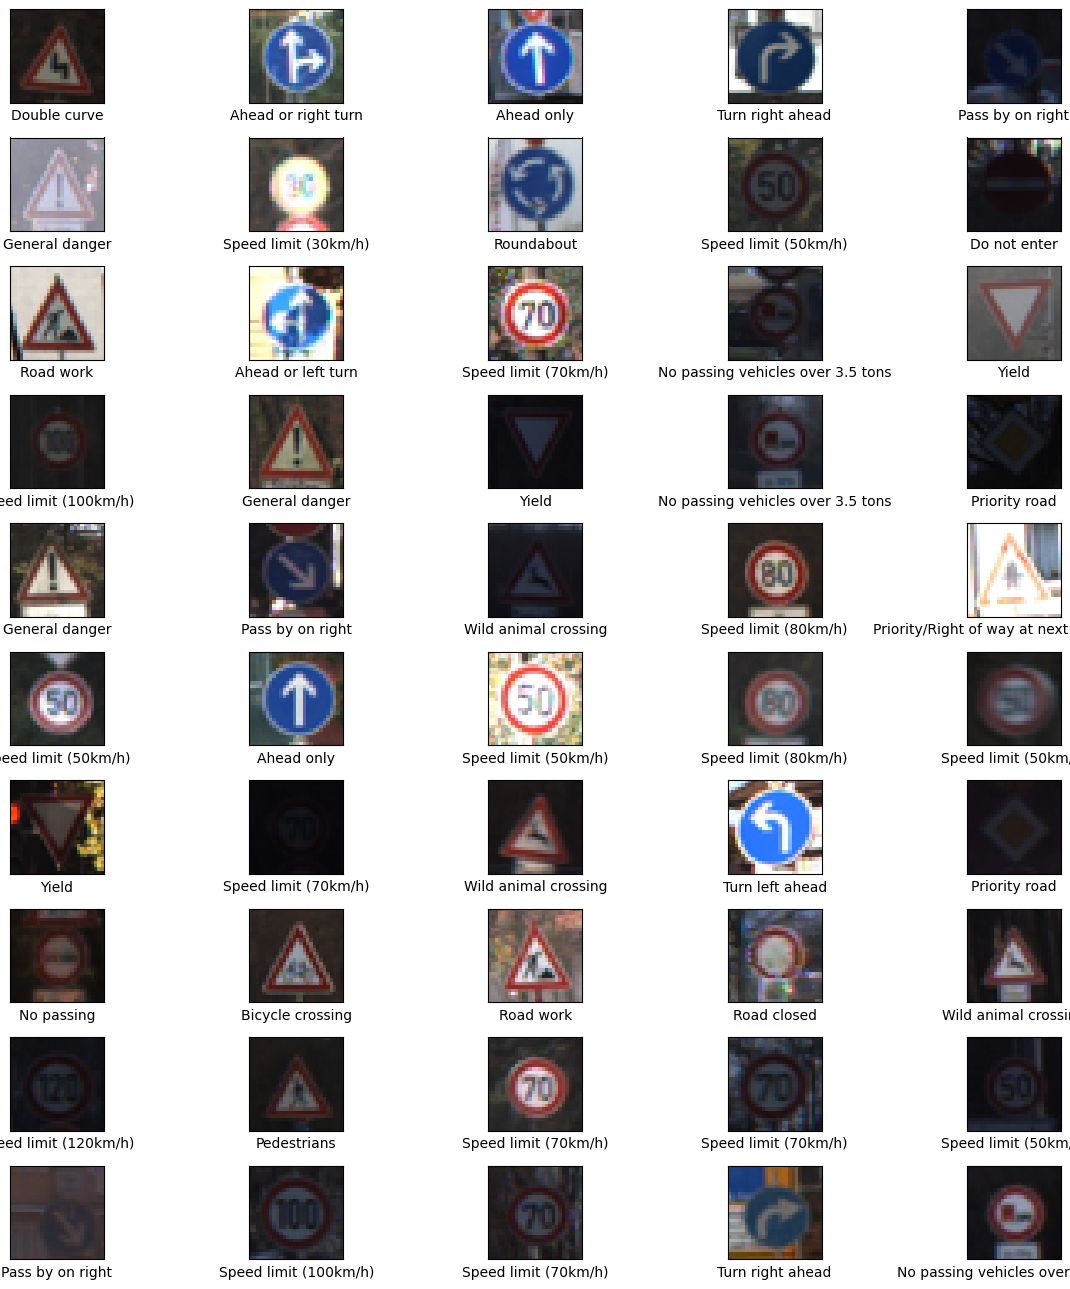

In [19]:
# Set figure size
plt.figure(figsize=(13,13))

# For loop to iterate through the images and create a subplot for each image with its label
for i in range(50):
    plt.subplot(10, 5, i+1)
    ax = plt.gca()
    plt.imshow(X_train[i])
    plt.xlabel(labels[y_train[i]])
    
    # Turn off tick labels
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    
    # Turn off tick marks
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()    
plt.show()

Back to data preprocessing.

In [20]:
# Reshape the image data to the 28x28 pixel format
X_train =  X_train.reshape(27446, 28, 28, 3).astype('float32')
X_valid =  X_valid.reshape(11763, 28, 28, 3).astype('float32')

In [21]:
# Covert the pixel integers to floats
X_train /= 255
X_valid /= 255

In [22]:
# Transform the labels into one-hot encodings
y_train = tf.keras.utils.to_categorical(y_train, categories)
y_valid = tf.keras.utils.to_categorical(y_valid, categories)

In [19]:
# Create a Sequential model
model = Sequential()

# Add the different layers of the CNN
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,3)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(categories, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Training and Tuning the Model

In [27]:
# Fit the model
#   The initial training and testing to get a baseline
model.fit(X_train, y_train, batch_size=64, epochs=30, verbose=1, validation_data=(X_valid, y_valid))

Epoch 1/30
429/429 [==============================] - 4s 8ms/step - loss: 1.4412 - accuracy: 0.6080 - val_loss: 0.3138 - val_accuracy: 0.9364
Epoch 2/30
429/429 [==============================] - 4s 8ms/step - loss: 0.4037 - accuracy: 0.8790 - val_loss: 0.1298 - val_accuracy: 0.9717
Epoch 3/30
429/429 [==============================] - 4s 9ms/step - loss: 0.2460 - accuracy: 0.9251 - val_loss: 0.0931 - val_accuracy: 0.9797
Epoch 4/30
429/429 [==============================] - 4s 9ms/step - loss: 0.1788 - accuracy: 0.9468 - val_loss: 0.0633 - val_accuracy: 0.9861
Epoch 5/30
429/429 [==============================] - 4s 8ms/step - loss: 0.1421 - accuracy: 0.9572 - val_loss: 0.0590 - val_accuracy: 0.9838
Epoch 6/30
429/429 [==============================] - 4s 9ms/step - loss: 0.1190 - accuracy: 0.9621 - val_loss: 0.0474 - val_accuracy: 0.9884
Epoch 7/30
429/429 [==============================] - 4s 9ms/step - loss: 0.0986 - accuracy: 0.9694 - val_loss: 0.0407 - val_accuracy: 0.9901
Epoch 

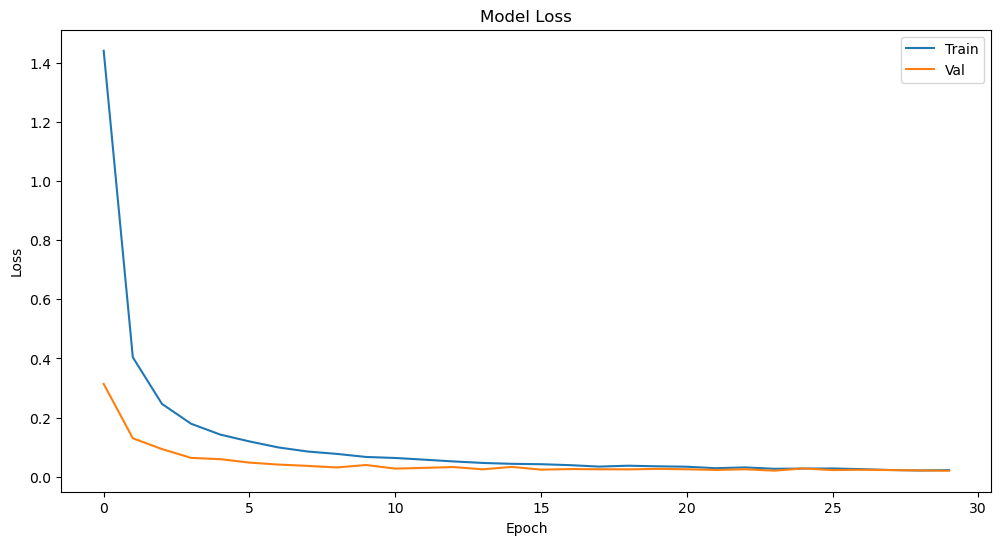

In [28]:
# Plot the model loss to see how the model performed
plt.figure(figsize=(12,6))
plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['val_loss'][:])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

#### The model will now go through a tuning process to see if it can be improved upon.

In [29]:
# The tuning process will create a new folder containing the trials used in the tuning process.
#   This block is to delete that folder every time a new attempt to tune the model is made so no problems occur.
import shutil

folder_path = "my_dir/intro_to_kt/"

# Check if the folder exists before attempting to delete it
if os.path.exists(folder_path):
    # Remove the folder and its contents
    shutil.rmtree(folder_path)
    print(f"The folder '{folder_path}' has been deleted.")
else:
    print(f"The folder '{folder_path}' does not exist.")

The folder 'my_dir/intro_to_kt/' has been deleted.


In [30]:
# Create a function that will use the same model as before
#   The layers will be given a range of values so the tuner can fins the optimal ones.
def model_builder(hp):
    # Create the model
    model = Sequential()
    
    # Add the layers
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,3)))
    
    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    
    model.add(Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'))

    model.add(Dropout(0.4))
    
    # The final layer 
    model.add(Dense(categories, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [31]:
# Create a tuner using the Hyperband tuner
tuner = kt.Hyperband(model_builder, objective='val_accuracy',
                     max_epochs=10, factor=3, 
                     directory='my_dir',
                     project_name='intro_to_kt')

In [32]:
# Create an early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [33]:
# Tune the model
tuner.search(X_train, y_train, epochs=30, validation_split=0.3, callbacks=[stop_early])

Trial 30 Complete [00h 00m 55s]
val_accuracy: 0.9876123070716858

Best val_accuracy So Far: 0.9907699227333069
Total elapsed time: 00h 11m 23s


In [34]:
# Get the best parameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print out the best parameters for each layer
print(f"First convolutional layer: {best_hps.get('conv_1_filter')}")
print(f"First convolutional kernel: {best_hps.get('conv_1_kernel')}")
print(f"Second convolutional layer: {best_hps.get('conv_2_filter')}")
print(f"Second convolutional kernel: {best_hps.get('conv_2_kernel')}")
print(f"Dense neurons: {best_hps.get('dense_1_units')}")

First convolutional layer: 32
First convolutional kernel: 3
Second convolutional layer: 48
Second convolutional kernel: 3
Dense neurons: 96


In [35]:
# Create and train the model using the best parameters
modelHT = tuner.hypermodel.build(best_hps)
history = modelHT.fit(X_train, y_train, epochs=30, verbose=1, validation_split=0.3)

Epoch 1/30
601/601 [==============================] - 6s 9ms/step - loss: 1.5988 - accuracy: 0.5646 - val_loss: 0.4389 - val_accuracy: 0.8991
Epoch 2/30
601/601 [==============================] - 5s 9ms/step - loss: 0.5572 - accuracy: 0.8319 - val_loss: 0.1964 - val_accuracy: 0.9586
Epoch 3/30
601/601 [==============================] - 5s 9ms/step - loss: 0.3645 - accuracy: 0.8917 - val_loss: 0.1239 - val_accuracy: 0.9739
Epoch 4/30
601/601 [==============================] - 5s 9ms/step - loss: 0.2703 - accuracy: 0.9168 - val_loss: 0.0930 - val_accuracy: 0.9779
Epoch 5/30
601/601 [==============================] - 5s 9ms/step - loss: 0.2251 - accuracy: 0.9293 - val_loss: 0.0627 - val_accuracy: 0.9860
Epoch 6/30
601/601 [==============================] - 6s 9ms/step - loss: 0.1799 - accuracy: 0.9408 - val_loss: 0.0647 - val_accuracy: 0.9857
Epoch 7/30
601/601 [==============================] - 5s 9ms/step - loss: 0.1635 - accuracy: 0.9468 - val_loss: 0.0566 - val_accuracy: 0.9868
Epoch 

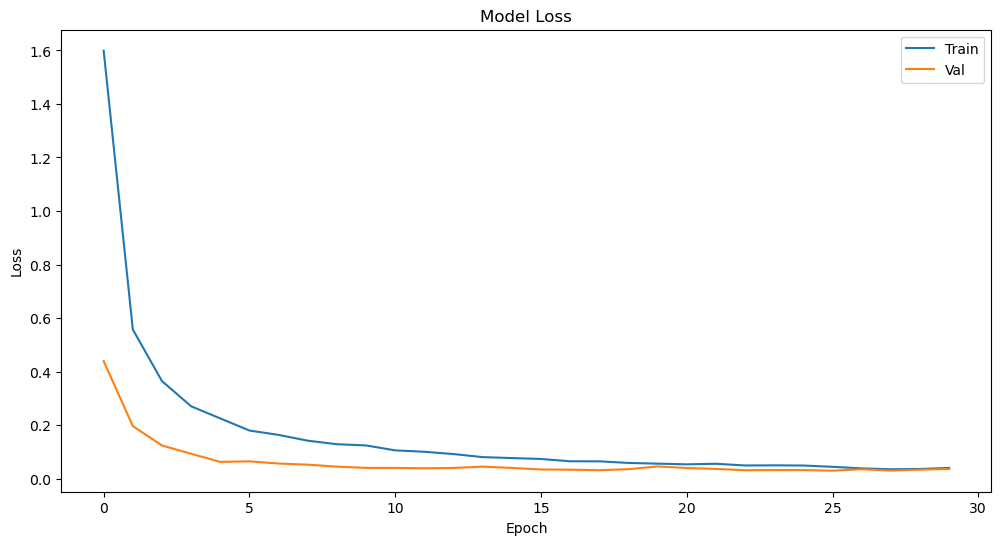

In [36]:
# Plot the new model's performance 
plt.figure(figsize=(12,6))
plt.plot(modelHT.history.history['loss'][:])
plt.plot(modelHT.history.history['val_loss'][:])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [37]:
# Find the best epoch amount
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 26


In [38]:
# Recreate and train the model using the best parameters and epoch amount
hypermodel = tuner.hypermodel.build(best_hps)

hypermodel.fit(X_train, y_train, epochs=best_epoch, verbose=1, validation_split=0.3)

Epoch 1/26
601/601 [==============================] - 6s 9ms/step - loss: 1.6247 - accuracy: 0.5607 - val_loss: 0.3949 - val_accuracy: 0.9116
Epoch 2/26
601/601 [==============================] - 5s 8ms/step - loss: 0.4948 - accuracy: 0.8552 - val_loss: 0.1686 - val_accuracy: 0.9564
Epoch 3/26
601/601 [==============================] - 5s 8ms/step - loss: 0.3016 - accuracy: 0.9092 - val_loss: 0.1085 - val_accuracy: 0.9755
Epoch 4/26
601/601 [==============================] - 5s 8ms/step - loss: 0.2218 - accuracy: 0.9341 - val_loss: 0.0862 - val_accuracy: 0.9783
Epoch 5/26
601/601 [==============================] - 5s 8ms/step - loss: 0.1718 - accuracy: 0.9466 - val_loss: 0.0685 - val_accuracy: 0.9841
Epoch 6/26
601/601 [==============================] - 5s 8ms/step - loss: 0.1406 - accuracy: 0.9577 - val_loss: 0.0632 - val_accuracy: 0.9849
Epoch 7/26
601/601 [==============================] - 5s 8ms/step - loss: 0.1245 - accuracy: 0.9610 - val_loss: 0.0518 - val_accuracy: 0.9876
Epoch 

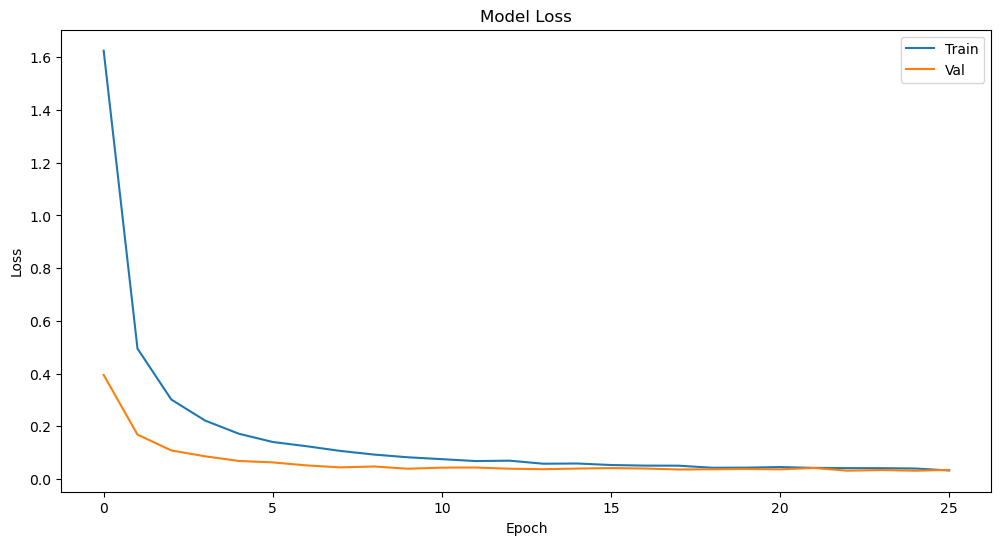

In [39]:
# Plot the final model's performance
plt.figure(figsize=(12,6))
plt.plot(hypermodel.history.history['loss'][:])
plt.plot(hypermodel.history.history['val_loss'][:])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [40]:
# Find and print the loss and accuracy
loss, accuracy = hypermodel.evaluate(X_valid, y_valid)

print(f'Loss: {loss*100:.2f}%')
print(f'Accuracy: {accuracy*100:.2f}%')

368/368 [==============================] - 1s 4ms/step - loss: 0.0286 - accuracy: 0.9943
Loss: 2.86%
Accuracy: 99.43%


The model seems to be performing well on the validation set with a 99.43% accuracy.

Time to create a confusion matrix to visualize the results.

In [41]:
# Import the required libraries
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

In [42]:
# Function to create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Observation')
    plt.xlabel('Prediction')

368/368 [==============================] - 1s 2ms/step


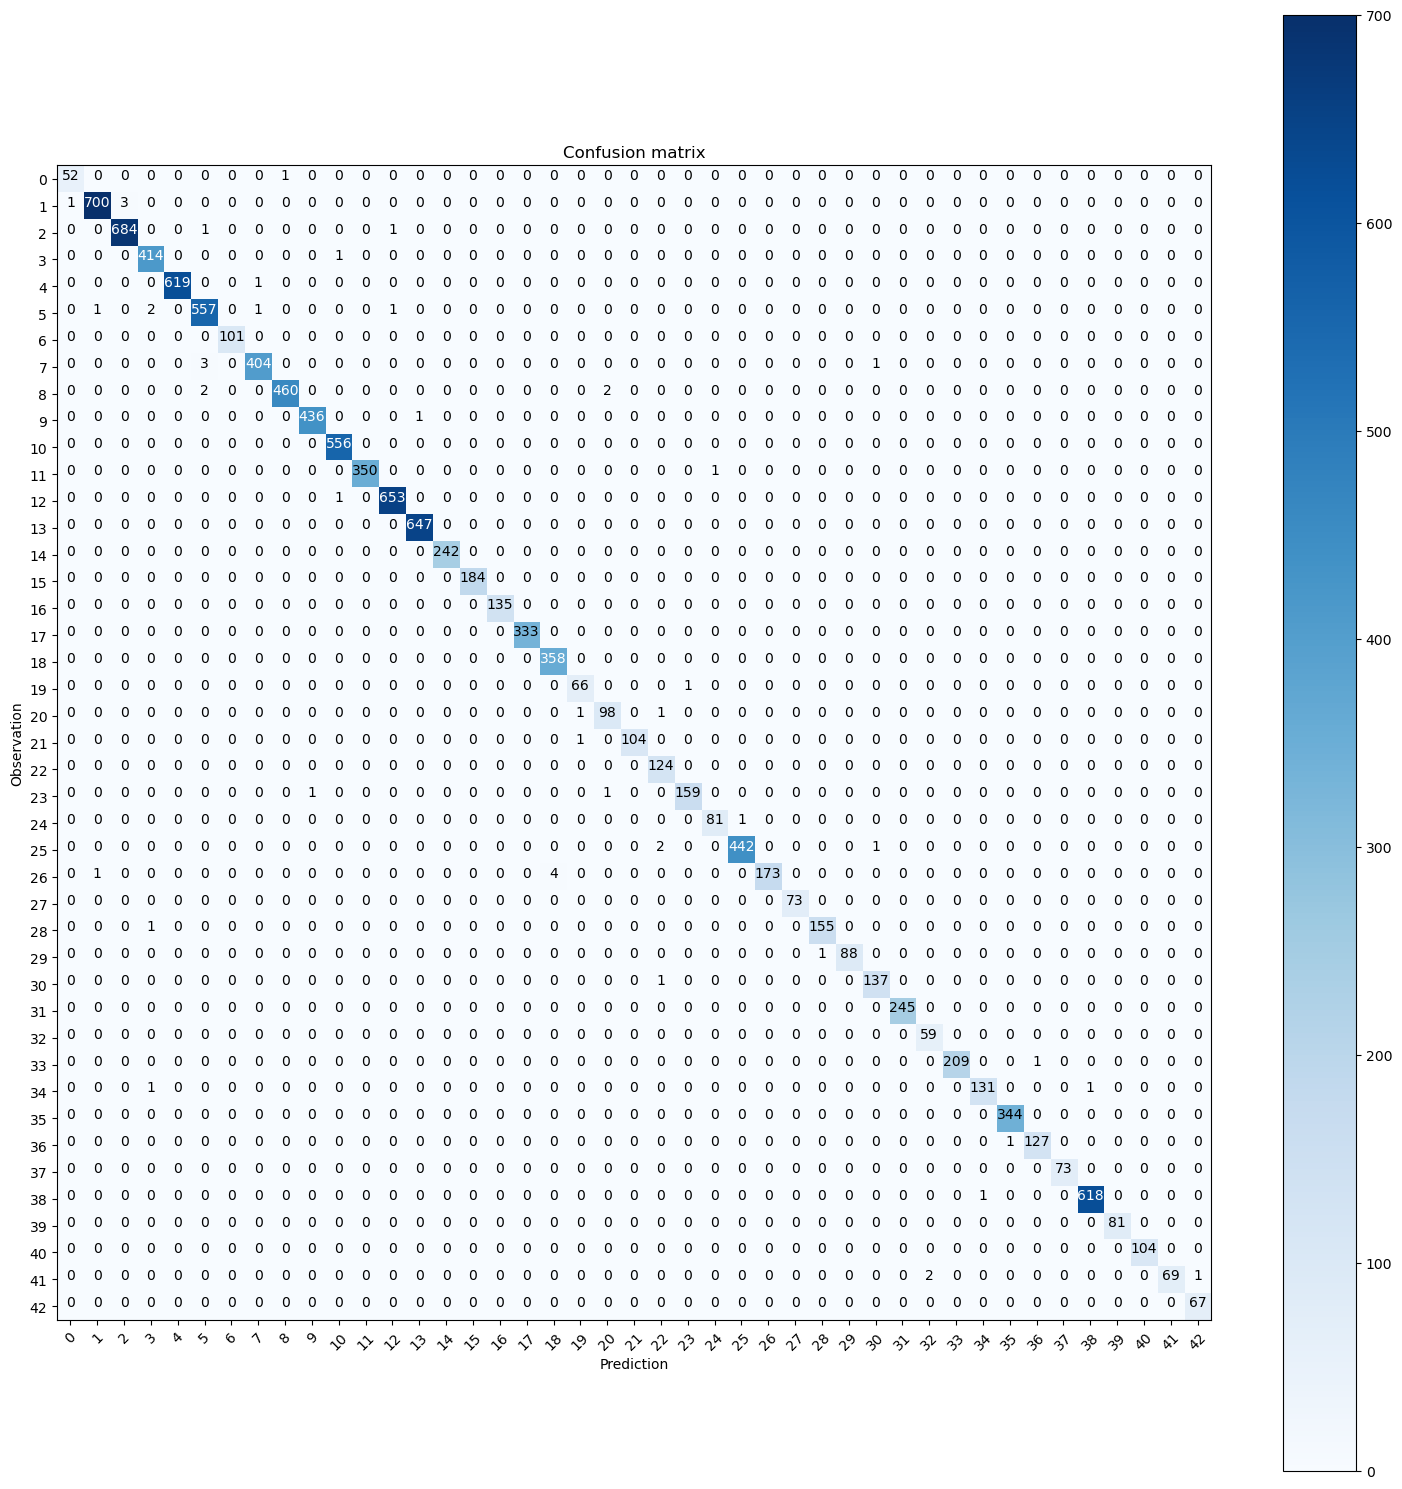

In [43]:
# Get model predictions
Y_pred = model.predict(X_valid)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_valid, axis = 1) 
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Plot the confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(confusion_mtx, classes = range(43))

The confusion matrix that very little incorrect classifications were made on the validation set. There are mostly zeroes surrounding the correct classification numbers. The center diagonal line is not dark blue due to the imbalance of sign categories the countplot showed earlier.

## Testing the model

Now it is time to test the model on a completely new dataset. We'll use the dataset the test dataframe created earlier is based on.

In [44]:
# Create an empty list to store the new images
testData = []

# For loop to iterate through the images
for i in testDF["Path"]:
    tempPath = data_path + '/' + str(i)
    
    # Add the images to an array and resize them
    tempArray = np.array(Image.open(tempPath).resize((28,28)))
    # Add the array to the list
    testData.append(tempArray)

# Convert the list and label values into arrays
X_test = np.array(testData)
y_test = np.array(testDF["ClassId"].values)

# Print the array shapes
print(X_test.shape)
print(y_test.shape)

(12630, 28, 28, 3)
(12630,)


In [45]:
# Reshape the image array to the 28x28 pixel values
X_test = X_test.reshape(12630, 28, 28, 3).astype('float32')

# Convert the pixel values into floats
X_test /= 255

In [46]:
# Transform the labels using one-hot encoding
y_test = tf.keras.utils.to_categorical(y_test, categories)

In [49]:
# Evaluate the final model using the test set
hypermodel.evaluate(X_test, y_test)

395/395 [==============================] - 1s 4ms/step - loss: 0.1650 - accuracy: 0.9688


[0.16504184901714325, 0.9688044190406799]

#### The final model had a 96.88% accuracy using the test set.

In [50]:
# Get the predictions
predictions = hypermodel.predict(X_test)

395/395 [==============================] - 1s 2ms/step


#### Time to display the incorrect predictions to see what the model was getting wrong.

In [51]:
# Create an empty list to store the incorrect predictions
incorrect_predictions = []

# For loop to iterate through the predictions
for i, (p, e) in enumerate(zip(predictions, y_test)):
    predicted, expected = np.argmax(p), np.argmax(e)
    
    # Add the incorrect predictions to the list
    if predicted != expected:
        incorrect_predictions.append((i, X_test[i], predicted, expected))
        
# Print the amount of incorrect predictions
print(len(incorrect_predictions))

394


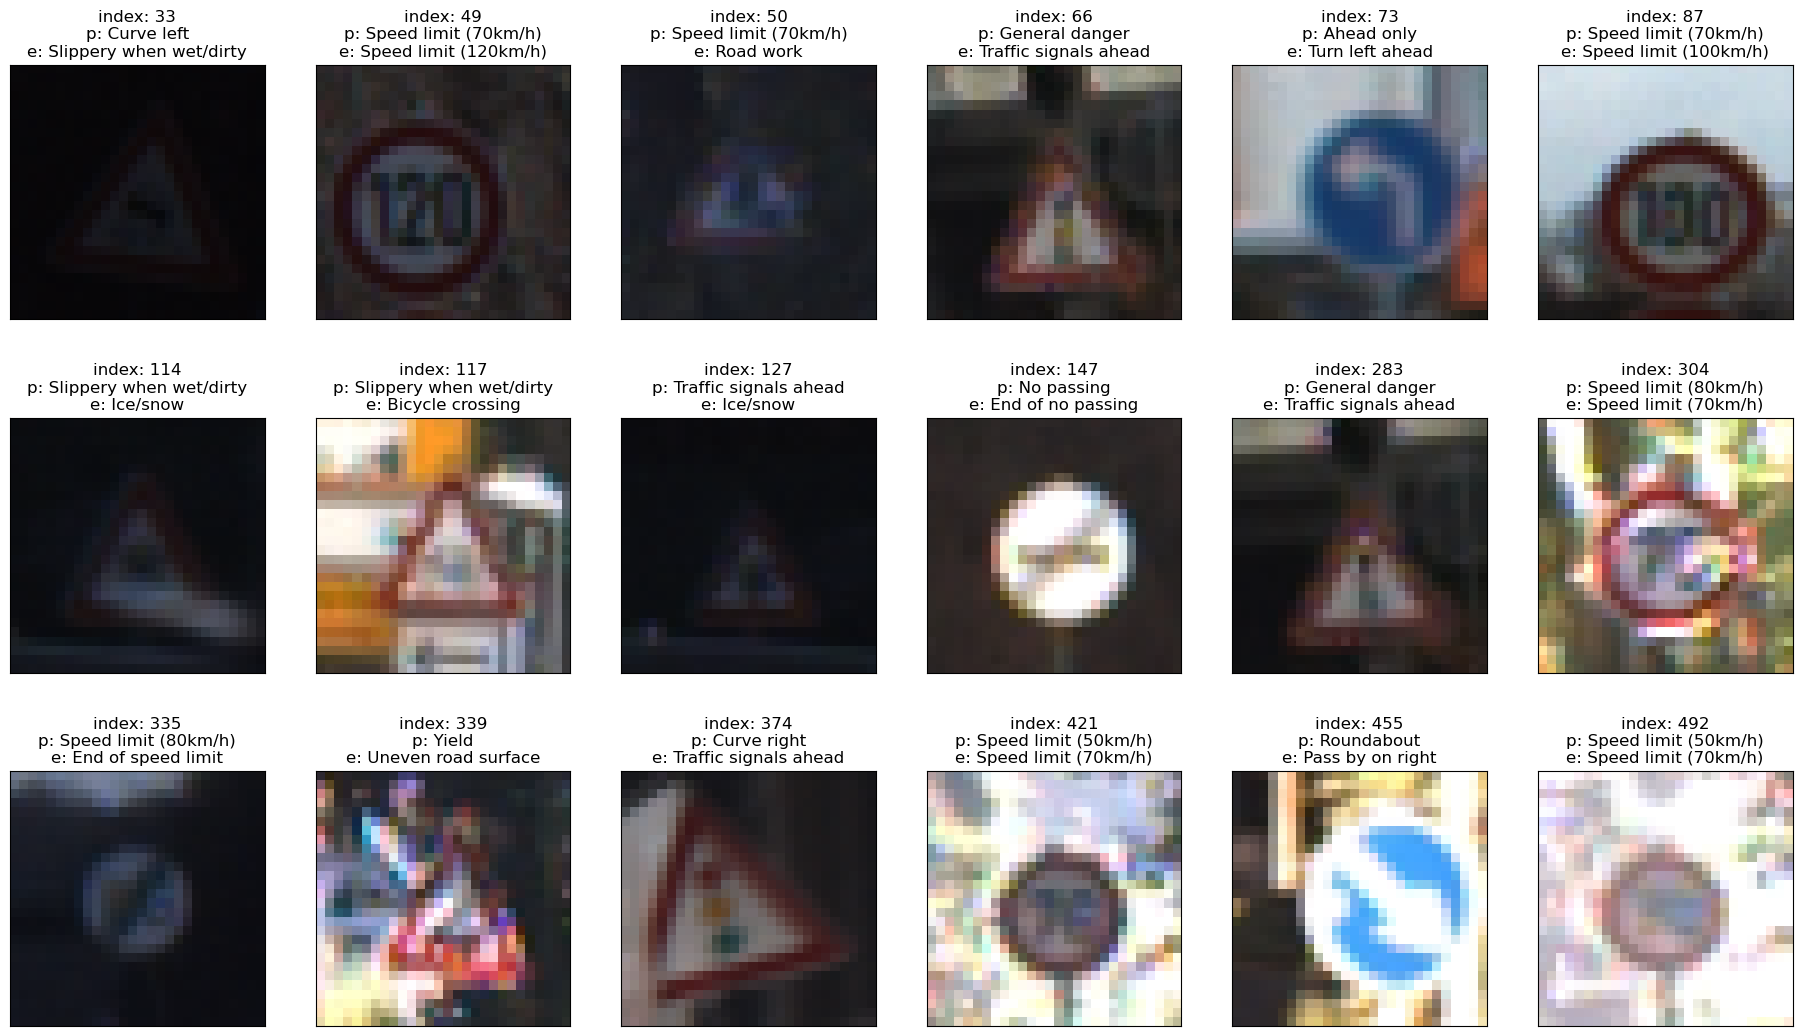

In [52]:
# Define the subplots to display the images
figure, axes = plt.subplots(nrows=3, ncols=6, figsize=(23,13))

# For loop to iterate through the incorrect predictions and display the images in the subplots
for axes, item in zip(axes.ravel(), incorrect_predictions):
    index, image, predicted, expected = item
    axes.imshow(image)
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_title(f'index: {index}\np: {labels[predicted]}\ne: {labels[expected]}')

plt.show()

## Conclusion

The model performed well and there is no indication of overfitting because the model still had a high accuracy when it was tested using the Test images, which were completely new images that were not part of the training or validation sets. While there are some outliers, the model seems to have trouble identifying very dark or very pixelated images. Better image quality could lead to a boost in performance.

## The Second Model

I created a second model because I felt that the first one was not performing as well as it could be. The only change was adding an additional convolutional layer and max pooling layer. The second model performed better, but due to technical and time constraints, I could not reorganize the notebook to have the second model be the primary model before the deadline. The new code blocks simply have sparse comments and new variable names. Other than those changes, they are identical to the code blocks used before.

In [54]:
model2 = Sequential()

model2.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,3)))
model2.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.3))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(categories, activation='softmax'))
           
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
model2.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_valid, y_valid))

Epoch 1/20
858/858 [==============================] - 8s 9ms/step - loss: 1.4794 - accuracy: 0.5819 - val_loss: 0.2125 - val_accuracy: 0.9455
Epoch 2/20
858/858 [==============================] - 7s 9ms/step - loss: 0.3029 - accuracy: 0.9065 - val_loss: 0.0702 - val_accuracy: 0.9833
Epoch 3/20
858/858 [==============================] - 7s 9ms/step - loss: 0.1670 - accuracy: 0.9478 - val_loss: 0.0462 - val_accuracy: 0.9889
Epoch 4/20
858/858 [==============================] - 7s 9ms/step - loss: 0.1241 - accuracy: 0.9626 - val_loss: 0.0271 - val_accuracy: 0.9929
Epoch 5/20
858/858 [==============================] - 7s 9ms/step - loss: 0.0946 - accuracy: 0.9712 - val_loss: 0.0234 - val_accuracy: 0.9946
Epoch 6/20
858/858 [==============================] - 7s 9ms/step - loss: 0.0814 - accuracy: 0.9746 - val_loss: 0.0220 - val_accuracy: 0.9939
Epoch 7/20
858/858 [==============================] - 7s 9ms/step - loss: 0.0671 - accuracy: 0.9793 - val_loss: 0.0349 - val_accuracy: 0.9902
Epoch 

In [56]:
def model_builder2(hp):
    # create model
    model = Sequential()
    
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,3)))
    
    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    
    model.add(Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'))

    model.add(Dropout(0.4))
    
    model.add(Dense(categories, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [57]:
import shutil

folder_path = "my_dir2/intro_to_kt/"

# Check if the folder exists before attempting to delete it
if os.path.exists(folder_path):
    # Remove the folder and its contents recursively
    shutil.rmtree(folder_path)
    print(f"The folder '{folder_path}' has been deleted.")
else:
    print(f"The folder '{folder_path}' does not exist.")

The folder 'my_dir2/intro_to_kt/' does not exist.


In [58]:
tuner2 = kt.Hyperband(model_builder2, objective='val_accuracy',
                     max_epochs=10, factor=3, 
                     directory='my_dir2',
                     project_name='intro_to_kt')

In [59]:
stop_early2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [60]:
tuner2.search(X_train, y_train, epochs=30, validation_split=0.3, callbacks=[stop_early2])

Trial 30 Complete [00h 00m 57s]
val_accuracy: 0.985547661781311

Best val_accuracy So Far: 0.995384931564331
Total elapsed time: 00h 11m 26s


In [61]:
best_hps2 = tuner2.get_best_hyperparameters(num_trials=1)[0]

print(f"First convolutional layer: {best_hps2.get('conv_1_filter')}")
print(f"First convolutional kernel: {best_hps2.get('conv_1_kernel')}")
print(f"Second convolutional layer: {best_hps2.get('conv_2_filter')}")
print(f"Second convolutional kernel: {best_hps2.get('conv_2_kernel')}")
print(f"Third convolutional layer: {best_hps2.get('conv_3_filter')}")
print(f"Third convolutional kernel: {best_hps2.get('conv_3_kernel')}")
print(f"Dense neurons: {best_hps2.get('dense_1_units')}")

First convolutional layer: 64
First convolutional kernel: 3
Second convolutional layer: 64
Second convolutional kernel: 3
Third convolutional layer: 64
Third convolutional kernel: 5
Dense neurons: 128


In [72]:
modelHT2 = tuner2.hypermodel.build(best_hps2)
history2 = modelHT2.fit(X_train, y_train, epochs=30, verbose=1, validation_split=0.3)

Epoch 1/30
601/601 [==============================] - 6s 9ms/step - loss: 1.6871 - accuracy: 0.5392 - val_loss: 0.2850 - val_accuracy: 0.9254
Epoch 2/30
601/601 [==============================] - 6s 10ms/step - loss: 0.3886 - accuracy: 0.8832 - val_loss: 0.1472 - val_accuracy: 0.9693
Epoch 3/30
601/601 [==============================] - 6s 9ms/step - loss: 0.2290 - accuracy: 0.9303 - val_loss: 0.0691 - val_accuracy: 0.9852
Epoch 4/30
601/601 [==============================] - 6s 9ms/step - loss: 0.1555 - accuracy: 0.9517 - val_loss: 0.0548 - val_accuracy: 0.9868
Epoch 5/30
601/601 [==============================] - 6s 9ms/step - loss: 0.1257 - accuracy: 0.9610 - val_loss: 0.0502 - val_accuracy: 0.9881
Epoch 6/30
601/601 [==============================] - 6s 9ms/step - loss: 0.1112 - accuracy: 0.9658 - val_loss: 0.0332 - val_accuracy: 0.9926
Epoch 7/30
601/601 [==============================] - 6s 9ms/step - loss: 0.0953 - accuracy: 0.9709 - val_loss: 0.0329 - val_accuracy: 0.9927
Epoch

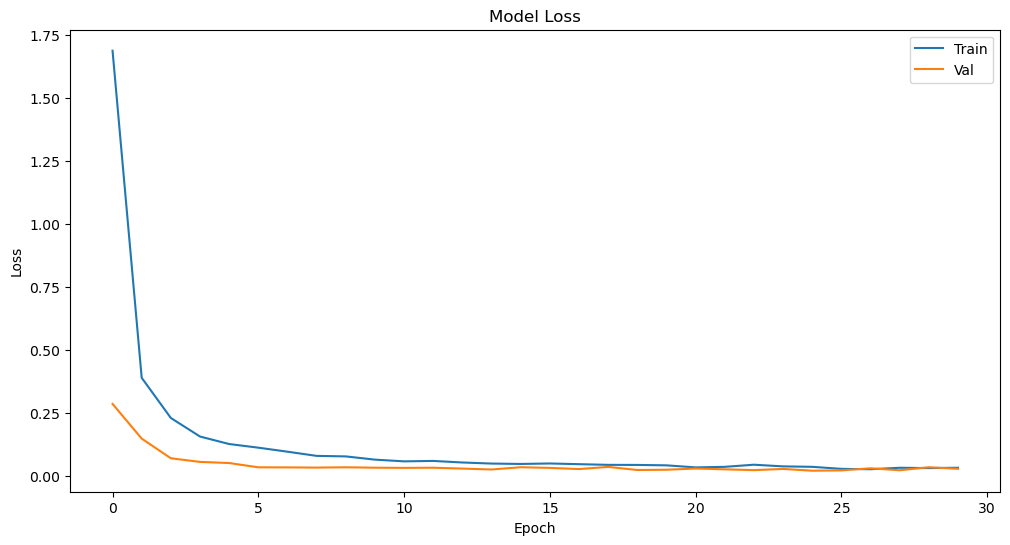

In [73]:
plt.figure(figsize=(12,6))
plt.plot(modelHT2.history.history['loss'][:])
plt.plot(modelHT2.history.history['val_loss'][:])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [80]:
val_acc_per_epoch2 = history2.history['val_accuracy']
best_epoch2 = val_acc_per_epoch2.index(max(val_acc_per_epoch2)) + 1
print('Best epoch: %d' % (best_epoch2,))

Best epoch: 23


In [81]:
hypermodel2 = tuner2.hypermodel.build(best_hps2)

hypermodel2.fit(X_train, y_train, epochs=best_epoch2, verbose=1, validation_split=0.3)

Epoch 1/23
601/601 [==============================] - 15s 24ms/step - loss: 1.8129 - accuracy: 0.4837 - val_loss: 0.3514 - val_accuracy: 0.9036
Epoch 2/23
601/601 [==============================] - 15s 25ms/step - loss: 0.4273 - accuracy: 0.8696 - val_loss: 0.1291 - val_accuracy: 0.9718
Epoch 3/23
601/601 [==============================] - 14s 24ms/step - loss: 0.2242 - accuracy: 0.9294 - val_loss: 0.0691 - val_accuracy: 0.9814
Epoch 4/23
601/601 [==============================] - 14s 24ms/step - loss: 0.1629 - accuracy: 0.9528 - val_loss: 0.0499 - val_accuracy: 0.9871
Epoch 5/23
601/601 [==============================] - 14s 24ms/step - loss: 0.1248 - accuracy: 0.9629 - val_loss: 0.0416 - val_accuracy: 0.9883
Epoch 6/23
601/601 [==============================] - 14s 24ms/step - loss: 0.0999 - accuracy: 0.9687 - val_loss: 0.0390 - val_accuracy: 0.9909
Epoch 7/23
601/601 [==============================] - 14s 24ms/step - loss: 0.0866 - accuracy: 0.9725 - val_loss: 0.0327 - val_accuracy:

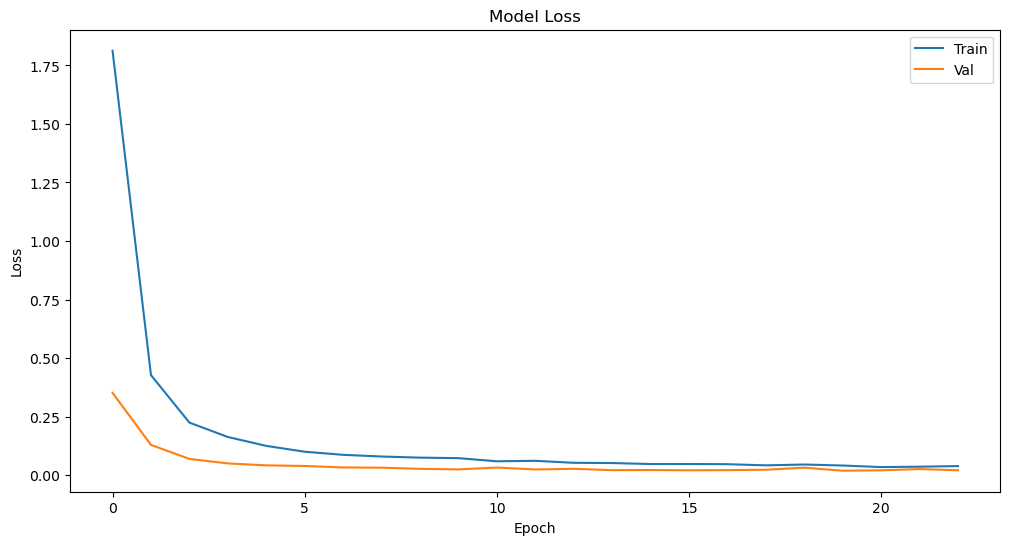

In [82]:
plt.figure(figsize=(12,6))
plt.plot(hypermodel2.history.history['loss'][:])
plt.plot(hypermodel2.history.history['val_loss'][:])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [83]:
# Evaluation of the initial model
model2.evaluate(X_test, y_test)

395/395 [==============================] - 3s 7ms/step - loss: 0.1258 - accuracy: 0.9709


[0.12580229341983795, 0.9709421992301941]

In [84]:
# Evaluation of the model with the best parameters
modelHT2.evaluate(X_test, y_test)

395/395 [==============================] - 3s 8ms/step - loss: 0.1409 - accuracy: 0.9704


[0.14090049266815186, 0.9703879356384277]

In [85]:
# Evaluation of the final model
hypermodel2.evaluate(X_test, y_test)

395/395 [==============================] - 3s 8ms/step - loss: 0.1071 - accuracy: 0.9744


[0.10710020363330841, 0.9744259715080261]

#### The model's accuracy increased from the initial model to the final model.

## Second Model Conclusion

The second model performed better than the first one. The new model has an accuracy of 97.44% while the first model has an accuracy of 96.88%. While the difference is small, it is still an accuracy boost.